### Import related package.

In [1]:
## tensorflow
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU, Flatten, Input, LSTM, SimpleRNN
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Metric

## environment setting
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.3)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))
tf.compat.v1.keras.backend.set_session(sess)

## Data preprocessing
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))

## Visulization
import matplotlib.pyplot as plt

## ARIMA and SARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import ndiffs
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm ##Automatically decide on ARIMA configuration
import statsmodels.api as sm

## The warning infomation dialog
import warnings
warnings.filterwarnings("ignore")

## Prepare data for (SVM and ANN)

In [2]:
def read(path):
    return pd.read_csv(path)

In [3]:
def buildTrain(train, pastWeek=4, futureWeek=4, defaultWeek=1):
    X_train, Y_train = [], []
    for i in range(train.shape[0]-futureWeek-pastWeek+1):
       
        X = np.array(train.iloc[i:i+defaultWeek])
        X = np.append(X,train["CCSP"].iloc[i+defaultWeek:i+pastWeek])
        
        X_train.append(X.reshape(X.size))
        Y_train.append(np.array(train.iloc[i+pastWeek:i+pastWeek+futureWeek]["CCSP"]))
    
    return np.array(X_train), np.array(Y_train)

In [4]:
def get_data():
    
    ## Read weekly copper price data
    path = "WeeklyFinalData.csv"
    data = read(path)
    
    date = data["Date"]
    data.drop("Date", axis=1, inplace=True)
    
    ## Add time lag (pastWeek=4, futureWeek=1)
    x_data, y_data = buildTrain(data)
    
    x_data = x_data[:-1]
    y_data = y_data[:-1,-1].reshape(-1,1)
    
    ## Data split
    x_train = x_data[0:int(x_data.shape[0]*0.8)]
    x_test = x_data[int(x_data.shape[0]*0.8):]
    
    y_train = y_data[0:int(y_data.shape[0]*0.8)]
    y_test = y_data[int(y_data.shape[0]*0.8):]
    
    return (date, x_train, x_test, y_train, y_test)

In [5]:
date, x_train, x_test, y_train, y_test = get_data()
x_train_scaled = sc.fit_transform(x_train)
x_test_scaled = sc.transform(x_test)
y_train_scaled = sc.fit_transform(y_train)


performance = pd.DataFrame({
    
    "Date":date[-y_test.shape[0]-1:-1],
    "Actual":y_test.reshape(-1)
})

performance.reset_index(inplace=True, drop=True)

In [6]:
performance["MW-LTS-500"] = pd.read_csv("MW-LTS-500.csv", header=None)

In [7]:
print("x_train_scaled",x_train_scaled.shape)
print("x_test_scaled",x_test_scaled.shape)
print("y_train_scaled",y_train_scaled.shape)
print("y_test",y_test.shape)

x_train_scaled (376, 18)
x_test_scaled (95, 18)
y_train_scaled (376, 1)
y_test (95, 1)


### Modeling for SVR

In [8]:
from sklearn.svm import SVR

In [9]:
svr_rbf = SVR(kernel = 'rbf', C=1e3 , gamma = 0.1)
svr_rbf.fit(x_train_scaled, y_train_scaled)
SVR_predict = svr_rbf.predict(x_test_scaled).reshape(-1,1)
performance["SVR"] = sc.inverse_transform(SVR_predict).reshape(-1)

### Modeling for ANN

In [10]:
def buildTwoLayerNN(input_shape):

    keras.backend.clear_session()
    model = Sequential()
    model.add(Dense(units=8, activation ="relu", input_shape=(input_shape,)))
    model.add(Dense(units=1)) 

    model.compile(optimizer="Adam", loss="mean_squared_error")

    return model

In [11]:
input_shape = x_train_scaled.shape[1]
model = buildTwoLayerNN(input_shape)
model.fit(x_train_scaled, y_train_scaled, epochs=300, batch_size=14, verbose=0)
ANN_predict = model.predict(x_test_scaled)
performance["ANN"] = sc.inverse_transform(ANN_predict).flatten()

## Prepare data for RNN-based model (RNN, LSTM, GRU)

In [12]:
def buildTrain(train, pastWeek, futureWeek=4, defaultWeek=1):
    X_train, Y_train = [], []
    for i in range(train.shape[0]-futureWeek-pastWeek+1):
        
        X = np.array(train.iloc[i:i+pastWeek,:])
        
        X_train.append(X.reshape(X.size))
        Y_train.append(np.array(train.iloc[i+pastWeek:i+pastWeek+futureWeek]["CCSP"]))
    return (np.array(X_train), np.array(Y_train))

In [13]:
def get_data(timeLag):
    
    ## Read weekly copper price data
    path = "WeeklyFinalData.csv"
    data = read(path)
    
    date = data["Date"]
    data.drop("Date", axis=1, inplace=True)
    
    ## Add time lag (pastWeek=4, futureWeek=1)
    x_data, y_data = buildTrain(data, timeLag)
    
    x_data = x_data[:-1]
    y_data = y_data[:-1,-1].reshape(-1,1)
    
    ## Data split
    x_train = x_data[0:int(x_data.shape[0]*0.8)]
    x_test = x_data[int(x_data.shape[0]*0.8):]
    
    y_train = y_data[0:int(y_data.shape[0]*0.8)]
    y_test = y_data[int(y_data.shape[0]*0.8):]
    
    
    return (x_train, x_test, y_train, y_test)

In [14]:
x_train, x_test, y_train, y_test = get_data(4)
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
## The number of forecasting variable (# of variable)
nb_input_factor = 15

## Data transformation
x_train_scaled = sc.fit_transform(x_train).reshape(-1,4,nb_input_factor)
x_test_scaled = sc.transform(x_test).reshape(-1,4,nb_input_factor)
y_train_scaled = sc.fit_transform(y_train)

### Modeling for RNN

In [15]:
def buildRNN(shape):
    
    keras.backend.clear_session()
    model = keras.Sequential()
    model.add(SimpleRNN(8, input_shape=(shape[1], shape[2])))
    model.add(Dense(1))
    model.compile(optimizer="Adam", loss="mse")
#     model.summary()
    return model

In [16]:
model = buildRNN(x_train_scaled.shape)
model.fit(x_train_scaled, y_train_scaled, epochs=300, batch_size=14, verbose=0)
RNN_predict = model.predict(x_test_scaled)
performance["RNN"] = sc.inverse_transform(RNN_predict).flatten()

### Modeling for LSTM

In [17]:
def buildLSTM(shape):
    
    model = Sequential()
    model.add(LSTM(8, input_shape=(shape[1], shape[2])))
    model.add(Dense(1))
    model.compile(optimizer="Adam", loss="mse")
#     model.summary()
    return model

In [18]:
model = buildLSTM(x_train_scaled.shape)
model.fit(x_train_scaled, y_train_scaled, epochs=300, batch_size=14, verbose=0)
LSTM_predict = model.predict(x_test_scaled)
performance["LSTM"] = sc.inverse_transform(LSTM_predict).flatten()

### Modeling for GRU

In [19]:
def buildGRU(shape):
    
    model = Sequential()
    model.add(GRU(8, input_shape=(shape[1], shape[2])))
    model.add(Dense(1))
    model.compile(optimizer="Adam", loss="mse")
#     model.summary()
    return model

In [20]:
model = buildGRU(x_train_scaled.shape)
model.fit(x_train_scaled, y_train_scaled, epochs=300, batch_size=14, verbose=0)
GRU_predict = model.predict(x_test_scaled)
performance["GRU"] = sc.inverse_transform(GRU_predict).flatten()

## Prepare data for SARIMA

In [21]:
path = "WeeklyFinalData.csv"
data = read(path)
train = data["CCSP"][:-96]
test = data["CCSP"][-96:]
data = data["CCSP"]

### Model the SARIMA model

In [22]:
model = sm.tsa.statespace.SARIMAX(train, order=(1,1,0), seasonal_order=(0,1,2,53))
model_fit = model.fit()
pre = model_fit.forecast(95)
pre.reset_index(inplace=True, drop=True)
performance["SARIMA"]=pre

## Visualize for the result

In [23]:
performance.to_csv("forecast_result.csv", index=False)
performance = performance.drop(["Date"], axis=1)
performance.reset_index(inplace=True, drop=True)

In [24]:
performance

,Actual,MW-LTS-500,SVR,ANN,RNN,LSTM,GRU,SARIMA
0,50018.0,48841.68,47585.333390,47897.265625,47624.402344,48325.886719,47590.363281,49942.924131
1,49788.0,49256.95,48140.557837,47983.621094,47149.468750,48046.070312,47308.605469,49418.217093
2,50146.0,49344.99,48952.903932,48574.738281,48374.109375,48356.917969,47986.031250,49361.745874
3,49444.0,49158.11,49665.998760,49069.105469,49335.445312,49039.105469,48711.031250,48729.787072
4,49367.0,48837.90,49221.337009,48949.828125,49512.945312,49616.917969,49337.214844,47763.434534
...,...,...,...,...,...,...,...,...
90,54890.0,52676.75,47143.818942,47296.078125,42134.917969,39438.460938,39902.191406,48274.227610
91,57448.0,52383.80,47748.878503,47426.035156,41423.964844,39352.175781,39603.656250,48928.824014
92,57418.0,52883.99,48841.520936,47959.468750,41335.078125,39848.460938,39102.476562,49090.547609
93,58154.0,53338.99,49686.110063,48894.667969,42540.839844,40860.175781,39665.324219,49211.964475


# Plot a graph comparing the predicted value with the actual value.

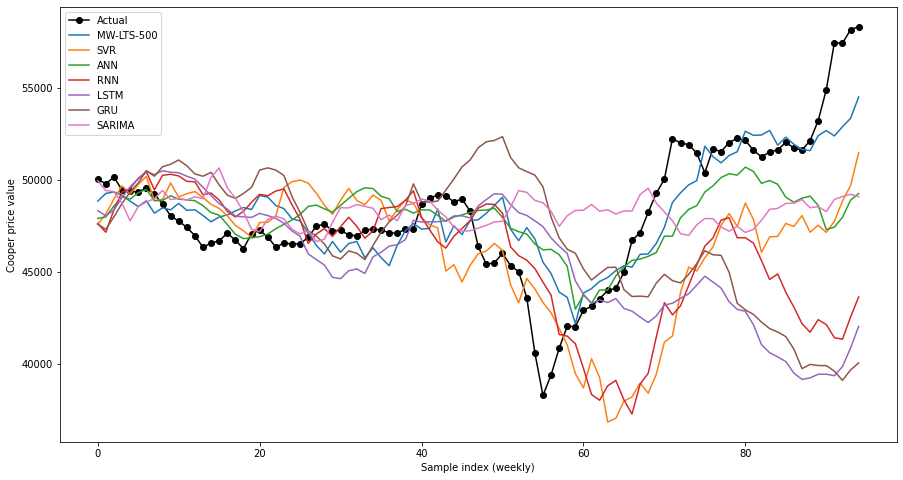

In [25]:
plt.figure(figsize=(15,8))

plt.plot(range(performance["Actual"].shape[0]), performance["Actual"], "-o",color='black', label = 'Actual')

for i in range(1,performance.shape[1]):
    t_data = performance.iloc[:,i]
    plt.plot(t_data, label=performance.columns[i])

plt.legend()
plt.xlabel("Sample index (weekly)")
plt.ylabel("Cooper price value")
plt.savefig('RMSE.png')

# Create the function to evaluate the performance of each model based on the RMSE, MAE, MAPE, and the accuracy from 500 to 3000 tolerance.

In [26]:
evaluation_results = pd.DataFrame(columns=["Model","MAE","MAPE","RMSE"])

mae = tf.keras.losses.MeanAbsoluteError()
mape = tf.keras.losses.MeanAbsolutePercentageError()
mse = tf.keras.losses.MeanSquaredError()

for i in range(1,performance.shape[1]):
    
    val_mae = mae(performance["Actual"], performance.iloc[:,i]).numpy()
    val_mape = mape(performance["Actual"], performance.iloc[:,i]).numpy()
    val_rmse = tf.math.sqrt(mse(performance["Actual"], performance.iloc[:,i])).numpy()
    accuracy = list()
    
    for threshold in range(500,3001,500):
        
        y_true = performance["Actual"]
        y_pred = performance.iloc[:,i]
        
        total_times = y_true.shape[0]
        correct_times = 0
        
        for _ in range(total_times): 

            correct_times = np.count_nonzero(abs(y_true-y_pred) < threshold)
        
        accuracy.append(correct_times/total_times)

    
    new_result = pd.DataFrame({

        "Model" : [performance.columns[i]],
        "MAE" : [val_mae],
        "MAPE" : [val_mape],
        "RMSE" : [val_rmse]
    })

    evaluation_results = evaluation_results.append(new_result, ignore_index=True)
evaluation_results

,Model,MAE,MAPE,RMSE
0,MW-LTS-500,1576.391846,3.330049,2080.754671
1,SVR,3359.374023,6.846053,4318.430965
2,ANN,2166.981934,4.442492,3073.794189
3,RNN,4011.593506,8.045130,5526.514160
4,LSTM,4528.354492,9.034131,6455.804199
5,GRU,4802.011719,9.704420,6544.741211
6,SARIMA,2873.975830,6.020123,3764.855907


In [27]:
evaluation_results.to_csv("evaluation.csv", index=False)